In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from omniflow import  OmniFlowPipeline
path = '../ckpts/v0.5'
pipeline = OmniFlowPipeline.load_pretrained(path,device='cuda')

/home/jacklishufan/miniconda3/envs/omniflow/lib/python3.10/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'omniflow.models.omni_flow.OmniFlowTransformerModel'>.load_config(...) followed by <class 'omniflow.models.omni_flow.OmniFlowTransformerModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
The config attributes {'image_bind': False} were passed to OmniFlowTransformerModel, but are not expected and will be ignored. Please verify your config.json configuration file.
/data0/jacklishufan/OmniFlow-public/omniflow/models/omni_flow.py:143: FutureWarning: Accessing config attribute `add_audio` directly via 'OmniFlowTransformerModel' object attribute is deprecat

Loaded ../ckpts/v0.5/transformer/diffusion_pytorch_model.bin:<All keys matched successfully>


In [5]:
from PIL import Image

In [6]:
def center_crop_and_resize(image_path, desired_size):
    # Open the image
    image = Image.open(image_path)
    
    # Get dimensions
    width, height = image.size
    
    # Calculate the size of the largest square
    new_side = min(width, height)
    
    # Calculate the cropping box
    left = (width - new_side) / 2
    top = (height - new_side) / 2
    right = (width + new_side) / 2
    bottom = (height + new_side) / 2
    
    # Crop the image to the largest square
    image = image.crop((left, top, right, bottom))
    
    # Resize the image to the desired size
    image = image.resize((desired_size, desired_size))
    
    return image



In [196]:
from transformers import SpeechT5HifiGan
import torch
vocoder = SpeechT5HifiGan.from_pretrained('cvssp/audioldm2',subfolder='vocoder')
vocoder.to('cuda')
@torch.no_grad()
def mel_spectrogram_to_waveform(
        vocoder, mel,
    ):
        if len(mel.size()) == 4:
            mel = mel.squeeze(1)
        #mel = mel.permute(0, 2, 1)
        waveform = vocoder(mel)
        waveform = waveform.cpu().detach().numpy()
        return waveform


In [74]:
pipeline.cfg_mode = 'old' # can play around with old and new

In [67]:
# pipeline.cfg_mode

## Image Captioning

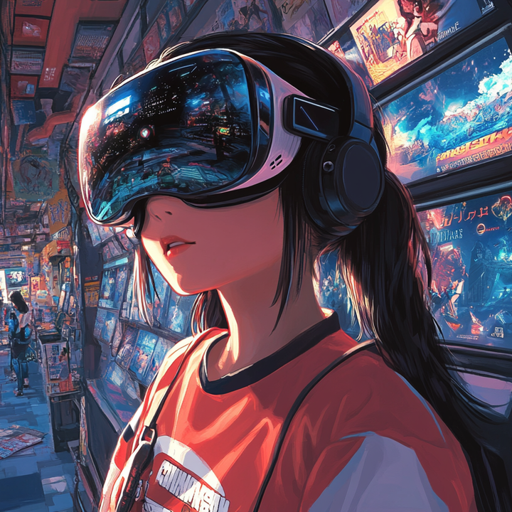

In [8]:
input_img = center_crop_and_resize('../assets/girl.png',512)
input_img

In [93]:

texts,texts2 = pipeline("",input_img=input_img,height=512,width=512,add_token_embed=0,task='i2t',guidance_scale=3,
                                      return_embed=False,num_inference_steps=30)

  0%|          | 0/30 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [94]:
texts

['<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s> a girl in a futuristic city selling music</s>']

## Text To Image

In [115]:
pipeline.cfg_mode = 'new'
imgs = pipeline("portrait of a cyberpunk girl with neon tattoos and a visor,staring intensely. Standing on top of a building",height=512,width=512,add_token_embed=0,task='t2i')

  0%|          | 0/28 [00:00<?, ?it/s]

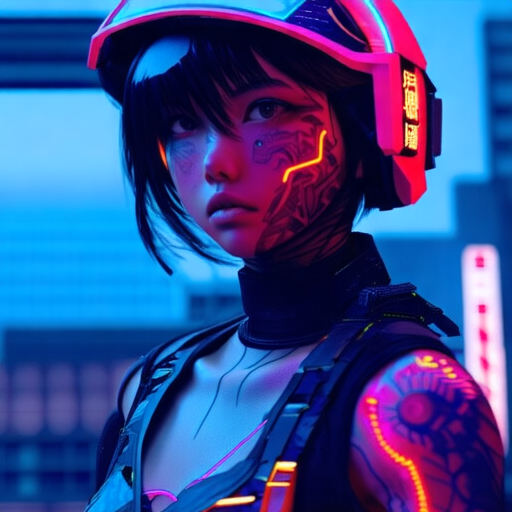

In [116]:
imgs[0][0]

## Audio To Image

In [366]:
import torchaudio
sound = '../assets/car engine.mp3'
wav,sr = torchaudio.load(sound)
Audio(wav.squeeze(), rate=sr) 

In [405]:
pipeline.cfg_mode = 'new'

img = pipeline(prompt="",input_aud=sound,add_token_embed=0,height=512,width=512,task='a2i',guidance_scale=8,no_clip=0,bypass=0)[0][0]

  0%|          | 0/28 [00:00<?, ?it/s]

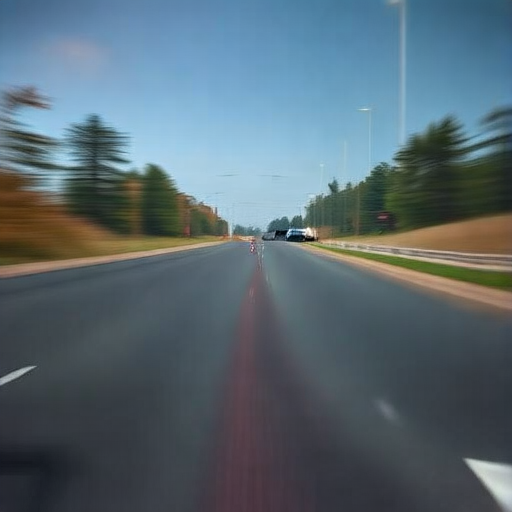

In [406]:
img

  0%|          | 0/28 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


  0%|          | 0/28 [00:00<?, ?it/s]

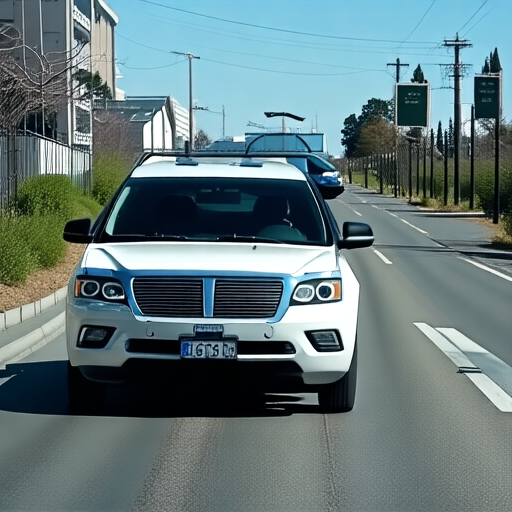

In [362]:
# alternatively, we can chose a path to do audio->text->image, this yields a slightly different distribution
pipeline.cfg_mode = 'new'
sound = '/home/jacklishufan/MMDiT/data/3840446777.mp4.mp3'
img = pipeline(prompt="",input_aud=sound,add_token_embed=0,height=512,width=512,task='a2i',guidance_scale=6,no_clip=0,bypass=1)[0][0]
img

## Text To Audio

In [203]:
aud = pipeline("A women is speaking",add_token_embed=0,task='t2a',drop_pool=False,guidance_scale=8,num_inference_steps=200)

  0%|          | 0/200 [00:00<?, ?it/s]

In [204]:
with torch.no_grad():
    wav = mel_spectrogram_to_waveform(vocoder,torch.tensor(aud[0]).cuda())
from IPython.display import Audio
Audio(wav.squeeze(), rate=16000)

In [207]:
aud = pipeline("car enging roaring",add_token_embed=0,task='t2a',drop_pool=False,guidance_scale=8,num_inference_steps=50)
with torch.no_grad():
    wav = mel_spectrogram_to_waveform(vocoder,torch.tensor(aud[0]).cuda())
from IPython.display import Audio
Audio(wav.squeeze(), rate=16000)

  0%|          | 0/50 [00:00<?, ?it/s]

## Audio To Text

In [408]:
pipeline("",
                                   guidance_scale=1.5,
                                   input_img=input_img,input_aud=sound,height=512,width=512,add_token_embed=1,task='a2t',drop_pool=False,
        mm_cfgs=[0.1,0,1],num_inference_steps=10)[0]

  0%|          | 0/10 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


['<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s> A vehicle is making a loud engine sound.</s>']

In [426]:
# import torchaudio
music = '../assets/music.mp3'
wav,sr = torchaudio.load(music)
Audio(wav.squeeze(), rate=sr) 


In [423]:
pipeline("",guidance_scale=2,
                                   input_img=input_img,input_aud='../assets/music.mp3',height=512,width=512,add_token_embed=1,task='a2t',drop_pool=False,num_inference_steps=30)[0]

  0%|          | 0/30 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


['<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s> Music is being synthesized.</s>']